# PRObabilistic Motion Primitives (PROMPs)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

## Generate a trajectory using a system dynamics
Consider a system having the following dynamics: $\dot{x} = Ax + Bu$, 

where $x$ is the state of the system, $A$ is the system matrix, $B$ is the control matrix and $u$ the control commands.

Here, let $x$ be a vector containing the one dimensional position and velocity, $ x = [p \quad\dot{p}]^T$. Note that each dimension requires a separate PROMPs trajectory.

Therefore dimension of $A$ is $2\times2$ (num_states x num_states), and $B$ is $2\times1$ (num_states x control_dims).

The next state $x_t$ can be obtained by integrating the dynamics discretely:

$$x_{t} = (I + A dt) + (B dt \times u)$$

Generate a set of demo trajectory using this dynamics (adding some noise for variations):

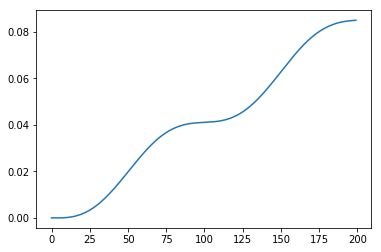

In [42]:
num_trajs = 100 # number of demo trajectories

# ----- the following system dynamics is used
A = np.array([ [0.,1.], [0., 0.] ])
B = np.array([ [0.], [1.] ]) 
start_x = np.array([[0],[0]]) # initial state (pos, vel)

noise = 1 # for randomising the control commands so as to generate slightly different trajectories
num_points = 200 # number of points in each trajectory. (Should be same as promps phase time_steps)

traj_list = []

# ----- Obtain next state using integrated system dynamics, previous state and control command
def next_x(prev_x, cmd):
    dt = 0.005 # (should be same as promps dt)
    return np.dot(np.eye(2) + A*dt, prev_x) + np.dot(B*dt, cmd)

pos_list = [] # list of position values (1 dimensional positions)
vel_list = [] # list of velocities

# ----- generate multiple demo trajectories by adding slight noise to the basic system dynamics
for _ in range(num_trajs):

    prev_x = start_x

    # ----- numpy arrays to hold the position and velocity trajectory points
    pos_traj = np.zeros(num_points)
    vel_traj = np.zeros(num_points)

    pos_traj[0] = start_x[0]
    vel_traj[0] = start_x[1]

    # ----- control commands in the form of sine wave
    cmd_list = np.sin(np.linspace(0,4*np.pi,num_points)) 
    cmd = cmd_list + np.random.randn(num_points)*0.1 # noise added for variations
    
    for i in range(1,num_points):

        x = next_x(prev_x, cmd[i-1])
        pos_traj[i] = x[0]
        vel_traj[i] = x[1]
        prev_x = x

    pos_list.append(pos_traj)
    vel_list.append(vel_traj)
    
# ----- plot and check one of the position trajectories
plt.plot(pos_list[0])

### Define Basis Function Parameters

In [43]:
#number of basis function
n_bfs = 35
#variance of the basis function
bfs_sigma = 0.0286
#centers of the basis function
bfs_centres = np.linspace(0, 1, n_bfs)

#list that stores all the weights
W = []

#mean and sigma of the weights
mean_W  = None
sigma_W = None

### Phase for the trajectory
Time evolves from 0 to 1. Phase defines how quickly the time evolves for a trajectory

In [50]:
dt = 0.005 # defined earlier


# phase_speed = 1 # default, actual speed of trajectory

def get_phase_variables(phase_speed):
    """
    This funciton gives the phase variables and 
    its first and second derivatives
    """
    phase_start = -dt
    time_steps = int(num_points/phase_speed) # defined earlier
    phase_end = phase_start + time_steps*dt
    # ----- derivative of phase variable
    Dz  = np.ones(time_steps)*phase_speed
    
    # ----- phase variable
    phase_z   = np.cumsum(Dz)*dt

    # ----- second derivative of phase variable
    DDz = np.diff(Dz)/dt
    DDz = np.hstack([DDz, DDz[-1]])
    
    return phase_z, Dz, DDz

def get_phase_from_time(time_steps):
    """
    This funciton is to convert a timestep
    to a phase
    """
    return time_steps/phase_end

def get_time_step(t):
    """
    This function is to compute the 
    time step of a phase
    """
    phase = get_phase_from_time(t)
    return int(phase*time_steps)

### Basis Function

In [45]:
def generate_basis_function(phase_z, phase_zd, phase_zdd):
    """
    This function generates the basis funciton, first derivative and second derivative
    from a phase
    Args:
    phase_z   = phase of the trajectory (type: np.array([time steps, 1]))
    phaze_zd  = velocity of the phase (type: np.array([time steps, 1]))
    phaze_zds = acceleration of the phase (type: np.array([time steps, 1]))
    
    Equations are from paper (https://link.springer.com/content/pdf/10.1007%2Fs10514-017-9648-7.pdf) 
    and their matlab implementation.
    """

    # basis functions
    phase_minus_centre = np.array(map(lambda x: x - bfs_centres, np.tile(phase_z, (n_bfs, 1)).T)).T

    #basis function
    Phi   = np.exp(-0.5 *np.power(phase_minus_centre/bfs_sigma, 2)) / (np.sqrt(2.*np.pi)*bfs_sigma)

    #first derivative of basis function
    PhiD  = np.multiply(Phi,  -phase_minus_centre/(bfs_sigma ** 2))

    #second derivative of basis function
    PhiDD = Phi/(-bfs_sigma ** 2) + np.multiply(-phase_minus_centre/(bfs_sigma ** 2), PhiD)

    #for normalization purposes
    sum_bfs    = np.sum(Phi,   axis=0)
    sum_bfsD   = np.sum(PhiD,  axis=0)
    sum_bfsDD  = np.sum(PhiDD, axis=0)

    # normalize according to the matlab implementation of imitation promps
    PhiD_normalized = ( (PhiD * sum_bfs - Phi * sum_bfsD) * 1./np.power(sum_bfs, 2) ) 

    Phi_normalized  = Phi/sum_bfs[None, :]

    tmp1 = Phi * (2 * np.power(sum_bfsD, 2) - np.multiply(sum_bfs, sum_bfsDD))

    tmp2 = tmp1 + PhiDD * np.power(sum_bfs, 2) - 2 * PhiD * sum_bfs * sum_bfsD

    #normalize acceleration
    PhiDD_normalized = tmp2 * (1./(np.power(sum_bfs, 3)))

    #adding phase dependency
    PhiDD_normalized = PhiDD_normalized * np.power(phase_zd, 2)  + PhiD_normalized * phase_zdd
    PhiD_normalized  = PhiD_normalized * phase_zd

    return Phi_normalized, PhiD_normalized, PhiDD_normalized

# Generate the Basis Function for the demo trajectory using the default phase values (i.e, phase speed = 1)
phase_z, Dz, DDz = get_phase_variables(1)
Phi, PhiD, PhiDD = generate_basis_function(phase_z, Dz, DDz)

### Train the PROMP

In [46]:
"""
Finds the weights of the 
given demonstration by first interpolating them
to 0-1 range and then finding the kernel weights
corresponding to each trajectory

import matplotlib.pyplot as plt
for k in range(35):
    plt.plot(self._Phi[k, :])
plt.show()
"""

for demo_traj in pos_list:

    interpolate = interp1d(phase_z, demo_traj, kind='cubic')

    #strech the trajectory to fit 0 to 1
    stretched_demo = interpolate(phase_z)[None,:]

    #compute the weights of the trajectory using the basis function
    w_demo_traj = np.dot(np.linalg.inv(np.dot(Phi, Phi.T) + 1e-12*np.eye(n_bfs) ), np.dot(Phi, stretched_demo.T)).T  # weights for each trajectory

    #append the weights to the list
    W.append(w_demo_traj.copy())

W =  np.asarray(W).squeeze()

# mean of weights
mean_W = np.mean(W, axis=0)

# covariance of weights
# w1 = np.array(map(lambda x: x - self._mean_W.T, self._W))
# self._sigma_W = np.dot(w1.T, w1)/self._W.shape[0]

sigma_W = np.cov(W.T)

### Sample a trajectory from the distribution

In [47]:
# ----- get a weight sample from the weight distribution
randomness = 1e-4
sample_W =  np.random.multivariate_normal(mean_W, randomness*sigma_W, 1).T

# ----- Computing the mean and sigma of the trajectory from the weight and basis functions
mean_of_sample_traj = np.dot(Phi.T, sample_W)
sigma_of_sample_traj = np.dot( np.dot(Phi.T, sigma_W), Phi)

### Function to plot mean and sigma

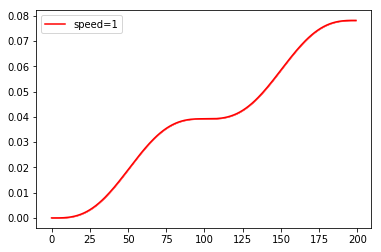

In [48]:
def plot_mean_and_sigma(mean, sigma, interval=3, color_mean=None, color_shading=None, label=''):

    """
    Expects mean = [Nx1] and Sigma [NxN]
    The computed sigma is NxN, so diag of that is taken to get the variance
    """

    lower_bound = mean - interval*np.diag(sigma)
    upper_bound = mean + interval*np.diag(sigma)

    # ----- plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), lower_bound, upper_bound, color=color_shading, alpha=.5)

    # ----- plot the mean on top
    plt.plot(mean, color_mean, label=label)

    # ----- removing the extra label handles
    handles, labels = plt.gca().get_legend_handles_labels()
    i =1
    while i<len(labels):
        if labels[i] in labels[:i]:
            del(labels[i])
            del(handles[i])
        else:
            i +=1

    plt.legend(handles, labels)
    
# ----- plot the generated trajectory
plot_mean_and_sigma(mean_of_sample_traj.squeeze(), sigma_of_sample_traj, color_mean='r', color_shading='r', label='speed=1')

### Generate trajectories for different speeds

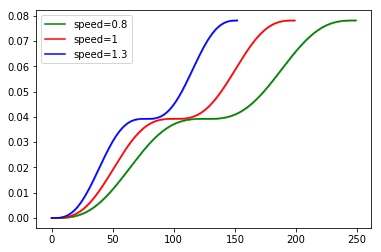

In [51]:
phase1_z, phase1_dz, phase1_ddz = get_phase_variables(0.8)
phase2_z, phase2_dz, phase2_ddz = get_phase_variables(1.3)

#create new basis functions
Phi1, PhiD1, PhiDD1  = generate_basis_function(phase_z=phase1_z, phase_zd=phase1_dz, phase_zdd=phase1_ddz)
Phi2, PhiD2, PhiDD2  = generate_basis_function(phase_z=phase2_z, phase_zd=phase2_dz, phase_zdd=phase2_ddz)

# ----- get mean and variance of basis functions for the new trajectories using the previously generated sample and the new basis functions
mean_of_sample_traj1 = np.dot(Phi1.T, sample_W)
sigma_of_sample_traj1 = np.dot( np.dot(Phi1.T, sigma_W), Phi1)

mean_of_sample_traj2 = np.dot(Phi2.T, sample_W)
sigma_of_sample_traj2 = np.dot( np.dot(Phi2.T, sigma_W), Phi2)

plot_mean_and_sigma(mean_of_sample_traj1.squeeze(), sigma_of_sample_traj1, color_mean='g', color_shading='g', label='speed=0.8')
plot_mean_and_sigma(mean_of_sample_traj.squeeze(), sigma_of_sample_traj, color_mean='r', color_shading='r', label='speed=1')
plot_mean_and_sigma(mean_of_sample_traj2.squeeze(), sigma_of_sample_traj2, color_mean='b', color_shading='b', label='speed=1.3')

### Adding via-points to the trajectories

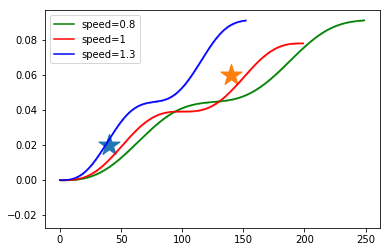

In [62]:
via_points = [(0.2, .02),(0.6, .06)]

# ----- speed 0.8
phase_speed = 0.8
new_mean_W   = mean_W
new_sigma_W  = sigma_W

phase1_z, phase1_dz, phase1_ddz = get_phase_variables(0.8)
phase2_z, phase2_dz, phase2_ddz = get_phase_variables(1.3)

#create new basis functions
Phi1, PhiD1, PhiDD1  = generate_basis_function(phase_z=phase1_z, phase_zd=phase1_dz, phase_zdd=phase1_ddz)
Phi2, PhiD2, PhiDD2  = generate_basis_function(phase_z=phase2_z, phase_zd=phase2_dz, phase_zdd=phase2_ddz)

traj_point_sigma=1e-6 # constraint strength for the via points (observation variance)
#loop for all viapoints, to transform 
#the mean and covariance
for viapoint in via_points:
    
    plt.scatter(viapoint[0]*num_points, viapoint[1], marker='*', s=500)
    
    # basis functions at observed time points

    PhiT, _, _ = generate_basis_function(phase_z=get_phase_from_time(viapoint[0]), phase_zd=phase_speed, phase_zdd=0.)
    
    # Conditioning
    aux = traj_point_sigma + np.dot(np.dot(PhiT.T, new_sigma_W), PhiT)
    # new weight mean conditioned on observations
    new_mean_W  = new_mean_W  + np.dot(np.dot(new_sigma_W, PhiT) * 1 / aux, (viapoint[1] - np.dot(PhiT.T, new_mean_W)))  
    new_sigma_W = new_sigma_W - np.dot(np.dot(new_sigma_W, PhiT) * 1 / aux, np.dot(PhiT.T, new_sigma_W))

#get a weight sample from the weight distribution
sample_W =  np.random.multivariate_normal(new_mean_W, randomness*new_sigma_W, 1).T

# ----- get mean and variance of basis functions for the new trajectories using the generated sample and the new basis functions
mean_of_sample_traj1 = np.dot(Phi1.T, sample_W)
sigma_of_sample_traj1 = np.dot( np.dot(Phi1.T, new_sigma_W), Phi1)

mean_of_sample_traj2 = np.dot(Phi2.T, sample_W)
sigma_of_sample_traj2 = np.dot( np.dot(Phi2.T, new_sigma_W), Phi2)

plot_mean_and_sigma(mean_of_sample_traj1.squeeze(), sigma_of_sample_traj1, color_mean='g', color_shading='g', label='speed=0.8')
plot_mean_and_sigma(mean_of_sample_traj.squeeze(), sigma_of_sample_traj, color_mean='r', color_shading='r', label='speed=1')
plot_mean_and_sigma(mean_of_sample_traj2.squeeze(), sigma_of_sample_traj2, color_mean='b', color_shading='b', label='speed=1.3')